In [1]:
import os
import time
import re
import requests
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
from itertools import combinations
from collections import Counter, defaultdict
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import lyricsgenius
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import json
import csv

/Users/josefinevoglhofer/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
songs = pd.read_csv('../../datadump/songs_no_dublicates.csv',
                    usecols=['recording_mbid','first_release_year','artist_mbid'])
writes = pd.read_csv('../../datadump/writerships.csv',
                     usecols=['recording_mbid','writer_id'])

songs = (songs
         .sort_values('first_release_year')
         .drop_duplicates('recording_mbid', keep='first'))

songs['decade'] = (songs.first_release_year // 10) * 10

adc = (
    songs
    .groupby(['artist_mbid','decade'])
    .size()
    .reset_index(name='count')
)
idx = adc.groupby('artist_mbid')['count'].idxmax()
artist_decade_map = (
    adc
    .loc[idx, ['artist_mbid','decade']]
    .set_index('artist_mbid')['decade']
    .to_dict()
)


def build_artist_graph_peak(decade_start):
    decade_end = decade_start + 9

    dec_songs = songs[
        songs['first_release_year'].between(decade_start, decade_end) &
        (songs['artist_mbid'].map(artist_decade_map) == decade_start)
    ]
    rec2art = dict(zip(dec_songs.recording_mbid, dec_songs.artist_mbid))

    writes_sub = writes[writes.recording_mbid.isin(rec2art)]

    pair_counter = Counter()
    edge_writers = defaultdict(set)
    for writer_id, grp in writes_sub.groupby('writer_id'):
        artists = sorted({ rec2art[r] for r in grp.recording_mbid })
        if len(artists) < 2:
            continue
        for a1, a2 in combinations(artists, 2):
            pair_counter[(a1, a2)] += 1
            edge_writers[(a1, a2)].add(writer_id)

    G = nx.Graph()
    for (a1, a2), w in pair_counter.items():
        G.add_edge(a1, a2,
                   weight=w,
                   writers=list(edge_writers[(a1, a2)]))
    return G


artist_graphs_peak = {}
for start in range(1960, 2030, 10):
    label = f"{start}s"
    G = build_artist_graph_peak(start)
    artist_graphs_peak[label] = G
    print(f"{label}: {G.number_of_nodes():>4} noder  | {G.number_of_edges():>6} kanter")

1960s:    9 noder  |     15 kanter
1970s:    5 noder  |      7 kanter
1980s:    2 noder  |      1 kanter
1990s:   78 noder  |   1143 kanter
2000s:  195 noder  |   5959 kanter
2010s:  137 noder  |   2682 kanter
2020s:   73 noder  |    568 kanter


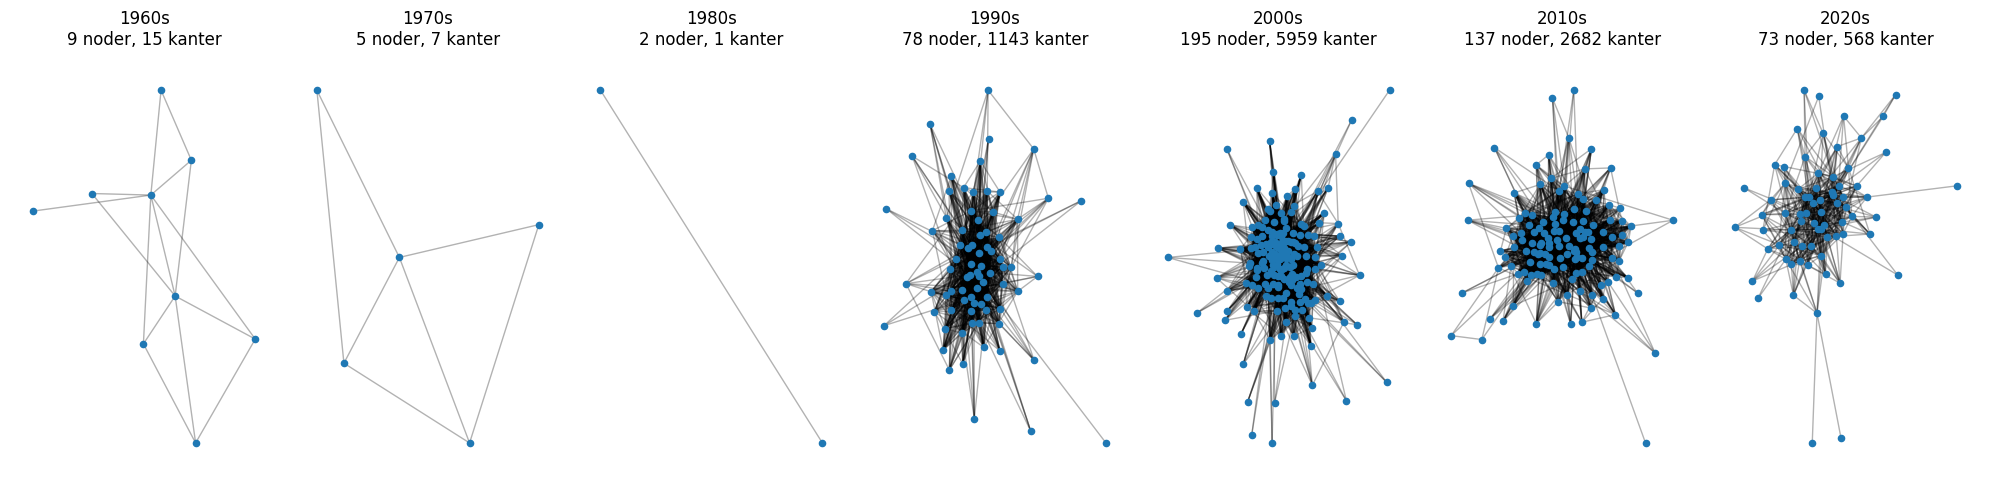

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

decades = ['1960s','1970s','1980s','1990s','2000s','2010s','2020s']

fig, axes = plt.subplots(1, len(decades), figsize=(20, 5))

for ax, decade in zip(axes, decades):
    G = artist_graphs_peak.get(decade, nx.Graph())
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=20, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)
    ax.set_title(f"{decade}\n{G.number_of_nodes()} noder, {G.number_of_edges()} kanter")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
artist_lookup = pd.read_csv('../../datadump/artists_all.csv',
                           usecols=['artist_mbid','name'],
                           dtype=str)
artist_dict = artist_lookup.set_index('artist_mbid')['name'].to_dict()

In [20]:
input_dir = "../../public/flest_udgivelser"
output_dir = "../../public/flest_udgivelser_csv"
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".json"):
        with open(os.path.join(input_dir, filename), "r", encoding="utf-8") as f:
            data = json.load(f)

        decade = filename.replace(".json", "")
        output_path = os.path.join(output_dir, f"{decade}.csv")

        with open(output_path, "w", newline="", encoding="utf-8") as out:
            writer = csv.writer(out)
            writer.writerow(["artist_mbid", "artist_name", "community"])
            for node in data["nodes"]:
                writer.writerow([node["id"], node["name"], node["community"]])


import re

def load_communities_from_csv(folder):
    decade2comm = {}
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            match = re.search(r"(\d{4}s)", filename)  # matcher fx '1960s'
            if not match:
                continue
            decade = match.group(1)

            df = pd.read_csv(os.path.join(folder, filename))
            comm2nodes = defaultdict(list)
            for _, row in df.iterrows():
                comm2nodes[row["community"]].append(row["artist_mbid"])
            decade2comm[decade] = comm2nodes
    return decade2comm

all_comm2nodes_peak = load_communities_from_csv("../../public/flest_udgivelser_csv")

In [ ]:
CANDIDATE_SONGS = 40
TARGET_LYRICS   = 20
DATADIR         = "../../datadump"
OUT_DIR         = "community_lyrics_ovh"
os.makedirs(OUT_DIR, exist_ok=True)
id_to_name = artists.set_index('artist_mbid')['name'].to_dict()

def fetch_lyrics_ovh(artist: str, title: str) -> str:
    url = f"https://api.lyrics.ovh/v1/{requests.utils.quote(artist)}/{requests.utils.quote(title)}"
    try:
        r = requests.get(url, timeout=5)
        if r.status_code == 200:
            return r.json().get("lyrics", "")
    except Exception:
        pass
    return ""

def clean_lyrics(text: str) -> str:
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"^[A-Za-z0-9 ]+:\s*", "", text, flags=re.MULTILINE)
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    return "\n".join(lines)

for decade, G in artist_graphs_peak.items():
    comm2nodes = all_comm2nodes_peak.get(decade, {})
    if not comm2nodes:
        continue

    for comm_id, members in comm2nodes.items():
        label = f"{decade}_comm{comm_id}"
        print(f"\n▶ Behandler {label}: {len(members)} artister")

        eligible_writers = defaultdict(set)
        for u, v, data in G.edges(data=True):
            if u in members and v in members and "writers" in data:
                for w in data["writers"]:
                    eligible_writers[u].add(w)
                    eligible_writers[v].add(w)

        df = (
            writes
            .merge(songs[['recording_mbid','title','artist_mbid']],
                   on='recording_mbid', how='inner')
        )
        df = df[df['artist_mbid'].isin(members)]
        mask = df.apply(lambda row: row['writer_id'] in eligible_writers[row['artist_mbid']], axis=1)
        df = df[mask]

        df_songs = df[['recording_mbid','title','artist_mbid']].drop_duplicates('recording_mbid')
        if df_songs.empty:
            print("   ⚠ Ingen sange opfylder de nye, skærpede kriterier – springer over.")
            continue

        rows = []
        seen_recordings = set()
        while len(rows) < TARGET_LYRICS and len(seen_recordings) < len(df_songs):
            remaining = df_songs[~df_songs['recording_mbid'].isin(seen_recordings)]
            if remaining.empty:
                break
            row = remaining.sample(n=1, random_state=int(time.time())).iloc[0]
            seen_recordings.add(row['recording_mbid'])

            artist_name = id_to_name.get(row['artist_mbid'], "")
            title_clean = re.sub(r"\s*\(.*?\)", "", row['title']).strip()
            raw = fetch_lyrics_ovh(artist_name, title_clean)
            lyric = clean_lyrics(raw)
            if lyric:
                rows.append({
                    "recording_mbid": row["recording_mbid"],
                    "title":          row["title"],
                    "artist_name":    artist_name,
                    "lyrics":         lyric
                })
            time.sleep(1)

        # D) Gem lyrics
        out = pd.DataFrame(rows)
        path = os.path.join(OUT_DIR, f"{label}_lyrics.csv")
        out.to_csv(path, index=False, encoding="utf-8")
        print(f"   ✅ Gemt {len(rows)} lyrics i {path}")


▶ Behandler 1960s_comm0: 5 artister
   ✅ Gemt 7 lyrics i community_lyrics_ovh/1960s_comm0_lyrics.csv

▶ Behandler 1960s_comm1: 4 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1960s_comm1_lyrics.csv

▶ Behandler 1970s_comm0: 2 artister
   ✅ Gemt 0 lyrics i community_lyrics_ovh/1970s_comm0_lyrics.csv

▶ Behandler 1970s_comm1: 3 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1970s_comm1_lyrics.csv

▶ Behandler 1980s_comm0: 2 artister
   ✅ Gemt 2 lyrics i community_lyrics_ovh/1980s_comm0_lyrics.csv

▶ Behandler 1990s_comm0: 21 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1990s_comm0_lyrics.csv

▶ Behandler 1990s_comm1: 41 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1990s_comm1_lyrics.csv

▶ Behandler 1990s_comm2: 8 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1990s_comm2_lyrics.csv

▶ Behandler 1990s_comm3: 8 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1990s_comm3_lyrics.csv

▶ Behandler 2000s_comm1: 14 artister
   ✅ Gemt 20 lyrics i community_lyri

In [23]:
import os
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

LYRICS_DIR = "community_lyrics_ovh"
OUT_WC_TFIDF = "wordclouds_tfidf"
os.makedirs(OUT_WC_TFIDF, exist_ok=True)

nltk.download("stopwords", quiet=True)
STOP = stopwords.words("english")

for fname in os.listdir(LYRICS_DIR):
    if not fname.endswith("_lyrics.csv"): continue
    label = fname.replace("_lyrics.csv","")
    file_path = os.path.join(LYRICS_DIR, fname)
    if os.stat(file_path).st_size == 0:
        print(f"Skipping empty file: {fname}")
        continue
    try:
        df = pd.read_csv(file_path)
    except pd.errors.EmptyDataError:
        print(f"Skipping file with no data: {fname}")
        continue
    docs = df["lyrics"].fillna("").tolist()

    # simpel rens og stop‐liste
    def clean(txt):
        txt = re.sub(r"[^\w\s]"," ", txt.lower())
        return txt

    docs = [clean(d) for d in docs]
    vec = TfidfVectorizer(stop_words=STOP,
                          max_features=50,
                          token_pattern=r"(?u)\b\w\w+\b")
    X = vec.fit_transform(docs)
    terms = vec.get_feature_names_out()
    scores = X.sum(axis=0).A1
    freqs = dict(zip(terms, scores))

    wc = WordCloud(width=800, height=400, background_color="white")\
         .generate_from_frequencies(freqs)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF–IDF WordCloud: {label}")
    plt.savefig(f"{OUT_WC_TFIDF}/{label}_tfidf.png", dpi=150, bbox_inches="tight")
    plt.close()

Skipping file with no data: 1970s_comm0_lyrics.csv


In [ ]:
import pandas as pd

artist_lookup = pd.read_csv(
    '../../datadump/artists_all.csv',
    usecols=['artist_mbid', 'name'],
    dtype=str
)

artist_dict = artist_lookup.set_index('artist_mbid')['name'].to_dict()

In [ ]:
def gini(array):
    """Gini coefficient for inequality of degree distribution."""
    if len(array) == 0:
        return np.nan
    array = np.sort(np.array(array, dtype=float))
    n = len(array)
    cum = np.cumsum(array)
    return (n + 1 - 2 * cum.sum() / cum[-1]) / n

def safe_metric(func, *args, **kwargs):
    """Return NaN instead of blowing up on disconnected graphs."""
    try:
        return func(*args, **kwargs)
    except (nx.NetworkXError, ZeroDivisionError):
        return np.nan

def decade_metrics(G, top_n=5):
    """
    Compute a dictionary of graph statistics that are easy to interpret
    in a social-science write-up.
    """
    n = G.number_of_nodes()
    m = G.number_of_edges()
    deg   = dict(G.degree())
    deg_w = dict(G.degree(weight="weight"))
    degrees = np.array(list(deg.values()))

    if n > 0:
        GCC = max(nx.connected_components(G), key=len)
        sub = G.subgraph(GCC)
    else:
        sub = G

    return {
        "nodes"             : n,
        "edges"             : m,
        "avg_degree"        : degrees.mean()          if n else np.nan,
        "median_degree"     : np.median(degrees)      if n else np.nan,
        "degree_gini"       : gini(degrees),          # inequality measure
        "density"           : nx.density(G),
        "avg_clustering"    : safe_metric(nx.average_clustering, G, weight=None),
        "assortativity_deg" : safe_metric(nx.degree_assortativity_coefficient, G),
        "avg_path_length"   : safe_metric(nx.average_shortest_path_length, sub),
        "diameter"          : safe_metric(nx.diameter, sub),
        **{
            "n_communities": len(comms := list(nx.algorithms.community.greedy_modularity_communities(G))),
            "modularity"   : nx.algorithms.community.modularity(G, comms)
        },
        "top_writers"       : ", ".join(
            f"{wid}:{int(deg_w[wid])}"
            for wid, _ in Counter(deg_w).most_common(top_n)
        )
    }
records = []
for decade, G in artist_graphs_peak.items():
    if G.number_of_nodes() == 0:
        print(f"Skipping null graph for {decade}")
        continue
    rec = decade_metrics(G)
    rec["decade"] = decade
    records.append(rec)

metrics_df = (pd.DataFrame(records)
                .sort_values("decade")
                .set_index("decade")
                .round(3))

display(metrics_df)          
metrics_df.to_csv("decade_network_metrics_flest_udgivelser.csv")

/Users/josefinevoglhofer/Library/Python/3.9/lib/python/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


,nodes,edges,avg_degree,median_degree,degree_gini,density,avg_clustering,assortativity_deg,avg_path_length,diameter,n_communities,modularity,top_writers
decade,,,,,,,,,,,,,
1960s,9,15,3.333,3.0,0.281,0.417,0.589,-0.558,1.639,3,2,0.222,"e7495426-6e14-4429-b647-dbe700ad57d4:27, bc4ca..."
1970s,5,7,2.800,3.0,0.143,0.700,0.767,-0.500,1.300,2,2,-0.219,"354812d4-2dfb-4611-9a8f-8f8e795e48bf:33, 79251..."
1980s,2,1,1.000,1.0,0.000,1.000,0.000,NaN,1.000,1,1,0.000,"7b004920-b04e-4ff2-b2e5-55d8f1cc0522:4, 8439a3..."
1990s,78,1143,29.308,30.5,0.334,0.381,0.743,-0.200,1.646,3,3,0.086,"c3d14b41-a48d-488f-bfed-ce0597bb0b1f:437, 05ec..."
2000s,195,5959,61.118,58.0,0.372,0.315,0.718,-0.162,1.727,4,3,0.141,"197450cd-0124-4164-b723-3c22dd16494d:2260, fbe..."
2010s,137,2682,39.153,35.0,0.353,0.288,0.686,-0.142,1.761,3,3,0.282,"48896dee-a985-424d-9849-84802f7e79c9:900, 8be0..."
2020s,73,568,15.562,15.0,0.379,0.216,0.597,-0.110,1.974,4,3,0.214,"6f1a58bf-9b1b-49cf-a44a-6cefad7ae04f:139, 2729..."
